In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation

from snewpy.neutrino import Flavor
from snewpy.models.ccsn import Sukhbold_2015, Nakazato_2013
mpl.rc('font', size=20)
%matplotlib inline

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [19]:
# this function loads the model and runs ASTERIAs simulation, it returns the time sequence, signal and background
# as well as the model name

def model_sig_bkg(model_name, dt):
    if model_name == "Sukhbold_2015_27_LS220":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 27*u.Msun, 'eos': 'LS220'}}
    elif model_name == "Sukhbold_2015_27_SFHo":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 27*u.Msun, 'eos': 'SFHo'}}
    elif model_name == "Sukhbold_2015_9_LS220":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 9.6*u.Msun, 'eos': 'LS220'}}
    elif model_name == "Sukhbold_2015_9_SFHo":
        model = {'name': 'Sukhbold_2015',
                 'param':{'progenitor_mass': 9.6*u.Msun, 'eos': 'SFHo'}}
    elif model_name == "Nakazato_2013_20_100ms_0.02_shen":
        model = {'name': 'Nakazato_2013',
                 'param':{'progenitor_mass': 20*u.Msun, 'revival_time': 100*u.ms, 'metallicity': 0.02, 
                          'eos': 'shen'}}
    elif model_name == "Nakazato_2013_50_300ms_0.004_shen":
        model = {'name': 'Nakazato_2013',
                 'param':{'progenitor_mass': 50*u.Msun, 'revival_time': 300*u.ms, 'metallicity': 0.004, 
                          'eos': 'shen'}}
        
    sim = Simulation(model=model,
             distance=10* u.kpc, 
             Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
             tmin=-0.05*u.s, tmax=5.0*u.s, dt=0.1*u.ms,        
             #tmin=-0.35*u.s, tmax=15.44*u.s, dt=0.1*u.ms,
             hierarchy = 'normal',
             mixing_scheme = 'NoTransformation',
             geomscope = 'Gen2',
             include_wls = False)
    sim.run()

    #signal
    t, sig_i3 = sim.detector_hits(dt=dt, subdetector="i3")
    t, sig_dc = sim.detector_hits(dt=dt, subdetector="dc")
    t, sig_md = sim.detector_hits(dt=dt, subdetector="md")

    sig = [sig_i3, sig_dc, sig_md]

    
    #background
    bkg_i3 = sim.detector.i3_bg(dt=dt, size = len(sig_i3))
    bkg_dc = sim.detector.dc_bg(dt=dt, size = len(sig_dc))
    bkg_md = sim.detector.md_bg(dt=dt, size = len(sig_dc))
    
    bkg = [bkg_i3, bkg_dc, bkg_md]
    
    return t, sig, bkg, model

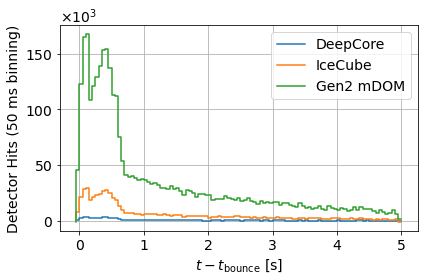

In [27]:
# plots the detector hit rate for the Sukhbold model
model = "Sukhbold_2015_27_LS220"
dt = 50*u.ms
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, tight_layout=True)

t, sig, bkg, m = model_sig_bkg(model, dt=dt)

sig_i3, sig_dc, sig_md = sig
bkg_i3, bkg_dc, bkg_md = bkg
ba_i3 = np.mean(bkg_i3)
ba_dc = np.mean(bkg_dc)
ba_md = np.mean(bkg_md)

ax.step(t, sig_dc+bkg_dc-ba_dc, label = "DeepCore")
ax.step(t, sig_i3+bkg_i3-ba_i3, label = "IceCube")
ax.step(t, sig_md+bkg_md-ba_md, label = "Gen2 mDOM")



# change y ticks to show a x 10^b
ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3), useOffset=False, useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.tick_params(labelsize=14)

#ax.set_yscale('log')
ax.grid()
ax.legend(fontsize = 14)
ax.set_xlabel(r'$t-t_{\rm bounce}$ [s]', fontsize=14)
ax.set_ylabel('Detector Hits (50 ms binning)', fontsize=14)
plt.tight_layout()
plt.savefig('sukhbold_spencer.pdf', dpi = 200, facecolor = 'white')